## Predicting used car prices

In this notebook, I'll work with the `Kaggle` dataset about used cars and their prices. The notebook first includes exploration of the dataset followed by prediction of prices.
dataset link:- https://www.kaggle.com/avikasliwal/used-cars-price-prediction

### Import libraries

I'll import datetime to handle year, numpy to work with arrays and pandas to read in the dataset files, matplotlib & seaborn for plotting and sklearn for various machine learning models.

In [1]:
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

C:\Users\vikasbhadoria\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Read dataset
I'll read the dataset and get information about it.

In [2]:
dataset = pd.read_csv('dataset.csv')
dataset.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [3]:
dataset.shape

(6019, 14)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


### I will split the dataset into 70% training and 30% testing data.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:, :-1], 
                                                    dataset.iloc[:, -1], 
                                                    test_size = 0.3, 
                                                    random_state = 42)

## Exploratory Data Analysis

Let's explore the various columns and draw information about how useful each column is. I'll also modify the test data based on training data.

### Index

The first column is the index for each data point and hence we can simply remove it.

In [6]:
X_train = X_train.iloc[:, 1:]
X_test = X_test.iloc[:, 1:]

### Name

Let's explore the various cars in the dataset.

In [7]:
X_train['Name'].value_counts()

Mahindra XUV500 W8 2WD              35
Maruti Swift VDI                    31
Maruti Ritz VDi                     26
Hyundai i10 Sportz                  25
Maruti Swift Dzire VDI              24
                                    ..
Hyundai Verna 1.6 VTVT AT SX         1
Honda Jazz Mode                      1
Maruti Swift VVT VXI                 1
Toyota Corolla Altis 1.8 G CVT       1
Hyundai Xcent 1.1 CRDi SX Option     1
Name: Name, Length: 1592, dtype: int64

The name of car is not so important, but the name of manufacturer is. Hence considering only the manufacturer name.

In [8]:
make_train = X_train['Name'].str.split(' ',expand = True)
make_test = X_test['Name'].str.split(' ',expand = True)

X_train['Manufacturer'] = make_train[0]
X_test["Manufacturer"] = make_test[0]

Text(0, 0.5, 'Count of cars')

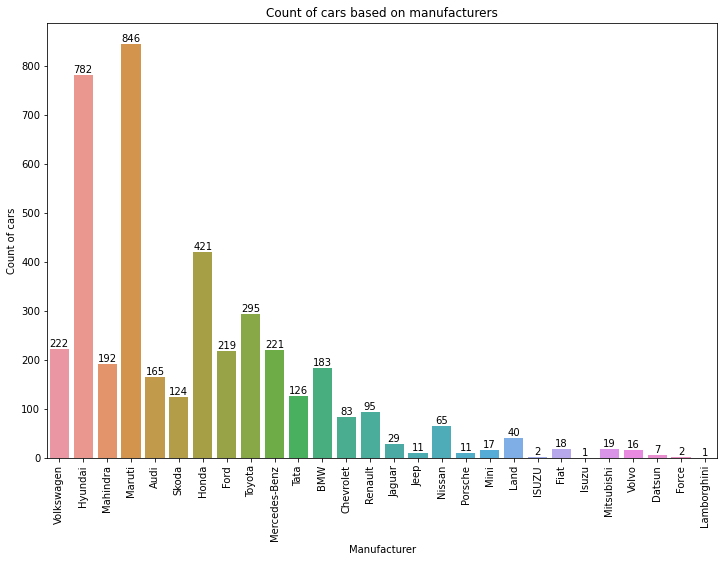

In [9]:
plt.figure(figsize = (12, 8))
plot = sns.countplot(x = 'Manufacturer', data = X_train)
plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')

plt.title("Count of cars based on manufacturers")
plt.xlabel("Manufacturer")
plt.ylabel("Count of cars")

Maximum cars in the dataset are by the manufacturer **Maruti** and there are no null values.

I'll also drop the `Name` column.

In [10]:
X_train.drop('Name',axis = 1,inplace = True)
X_test.drop('Name', axis = 1, inplace = True)

### Location

Location should not be a determinant for the price of a car and I will safely remove it.

In [11]:
X_train.drop('Location',axis = 1,inplace = True)
X_test.drop('Location', axis = 1, inplace = True)

### Year 

Year has no big important. But how old the car is, will be really important if I want to buy a second hand car.

In [12]:
curr_time = datetime.datetime.now()
X_train['Year'] = X_train['Year'].apply(lambda x: curr_time.year - x)
X_test['Year'] = X_test['Year'].apply(lambda x: curr_time.year - x)

### Fuel_Type, Transmission,  and Owner_Type

All these columns are categorical columns which should be converted to dummy variables before being used.

### Kilometers_Driven

`Kilometers_Driven` is a numerical column with a certain range of values.

In [13]:
X_train["Kilometers_Driven"]

4201     77000
4383     19947
1779     70963
4020    115195
3248     58752
         ...  
3772     27000
5191      9000
5226    140000
5390     76414
860      98000
Name: Kilometers_Driven, Length: 4213, dtype: int64

The data range is really varied and the high values might affect prediction, thus, it is really important that scaling be applied to this column for sure.

## Mileage

This column defines the mileage of the car. I need to extract the numerical value out of each string and save it.

In [14]:
mileage_train = X_train["Mileage"].str.split(" ", expand = True)
mileage_test = X_test["Mileage"].str.split(" ", expand = True)

X_train["Mileage"] = pd.to_numeric(mileage_train[0], errors = 'coerce')
X_test["Mileage"] = pd.to_numeric(mileage_test[0], errors = 'coerce')

Let's check for missing values.

In [15]:
print(sum(X_train["Mileage"].isnull()))
print(sum(X_test["Mileage"].isnull()))

1
1


There is one missing value in each. I'll replace the missing value with the mean value of the column based on the training data.

In [16]:
X_train['Mileage'].fillna(X_train['Mileage'].astype('float64').mean(),inplace = True)
X_test['Mileage'].fillna(X_test['Mileage'].astype('float64').mean(),inplace = True)

### Engine, Power and Seats

The `Engine` values are defined in CC so I need to remove `CC` from the data. Similarly, `Power` has bhp, so I'll remove `bhp` from it. Also, as there are missing values in `Engine`, `Power` and `Seats`, I'll again replace them with the mean.

In [17]:
cc_train = X_train["Engine"].str.split(" ", expand = True)
cc_test = X_test["Engine"].str.split(" ", expand = True)
X_train["Engine"] = pd.to_numeric(cc_train[0], errors = 'coerce')
X_test["Engine"] = pd.to_numeric(cc_test[0], errors = 'coerce')

bhp_train = X_train["Power"].str.split(" ", expand = True)
bhp_test = X_test["Power"].str.split(" ", expand = True)
X_train["Power"] = pd.to_numeric(bhp_train[0], errors = 'coerce')
X_test["Power"] = pd.to_numeric(bhp_test[0], errors = 'coerce')

In [18]:
X_train["Engine"].fillna(X_train["Engine"].astype("float64").mean(), inplace = True)
X_test["Engine"].fillna(X_train["Engine"].astype("float64").mean(), inplace = True)

X_train["Power"].fillna(X_train["Power"].astype("float64").mean(), inplace = True)
X_test["Power"].fillna(X_train["Power"].astype("float64").mean(), inplace = True)

X_train["Seats"].fillna(X_train["Seats"].astype("float64").mean(), inplace = True)
X_test["Seats"].fillna(X_train["Seats"].astype("float64").mean(), inplace = True)

### New Price

As most of the values are missing, I'll drop this column altogether.

In [19]:
X_train.drop(["New_Price"], axis = 1, inplace = True)
X_test.drop(["New_Price"], axis = 1, inplace = True)

## Data Processing

Now that I have worked with the training data, I will create dummy columns for categorical columns before I begin training.

In [20]:
X_train = pd.get_dummies(X_train, columns = ["Manufacturer", "Fuel_Type", "Transmission", "Owner_Type"],drop_first = True)

In [21]:
X_test = pd.get_dummies(X_test, columns = ["Manufacturer", "Fuel_Type", "Transmission", "Owner_Type"],drop_first = True)

It might be possible that the dummy column creation would be different in test and train data, thus, I'd fill in all missing columns with zeros.

In [22]:
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X_train.columns]
print(missing_cols)

{'Manufacturer_Isuzu', 'Manufacturer_Lamborghini', 'Manufacturer_ISUZU'}


In [23]:
X_train.shape,X_test.shape

((4213, 41), (1806, 41))

Finally, as the last step of data processing, I'll scale the data.

In [24]:
standardScaler = StandardScaler()
standardScaler.fit(X_train)
X_train = standardScaler.transform(X_train)
X_test = standardScaler.transform(X_test)

## Training and predicting

I'll create a **Linear Regression** model, an **XGboost** model and a **Random Forest** model to train on the data and use it for future predictions.

In [25]:
linearRegression = LinearRegression()
linearRegression.fit(X_train, y_train)
y_pred = linearRegression.predict(X_test)
r2_score(y_test, y_pred)

0.7008905424886804

In [26]:
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2_score(y_test, y_pred)

0.8871753272721278

As seen I got a better accuracy with RandomForest. But I did not hypertune the parameters. 
Now I will use **RandomizedSearchCV** for finding the best params of RandomForest for my given training data.

In [27]:
from sklearn.model_selection import RandomizedSearchCV

In [28]:
RF_params={'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [31]:
random_search_rf=RandomizedSearchCV(rf,param_distributions=RF_params,n_iter=10,n_jobs=-1,cv=5,verbose=3)

In [32]:
random_search_rf.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [33]:
random_search_rf.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [36]:
rf = RandomForestRegressor(n_estimators= 1600,
 min_samples_split= 5,
 min_samples_leaf= 1,
 max_features= 'sqrt',
 max_depth= 50,
 bootstrap= False)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2_score(y_test, y_pred)

0.9046699542418299

The **Random Forest model with hyper tuned parameters** performed the best with a R2 score of **0.90**